# Feature engineering - Taxi rides

In this notebook i'll show some possible engineered features on a dataset about taxi rides.

The dataset comes from here: http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml

I've taken the data file of January 2016 and kept only trips of 1st January to keep data size manageable ;-)

In [38]:
import pandas

df = pandas.read_csv('green_tripdata_2016_01_01.csv', parse_dates=['Pickup_datetime', 'Dropoff_datetime'])

df.head()

,VendorID,Pickup_datetime,Dropoff_datetime,Store_and_fwd_flag,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,...,Fare_amount,Extra,MTA_tax,Tip_amount,Tolls_amount,Ehail_fee,improvement_surcharge,Total_amount,Payment_type,Trip_type
0,2,2016-01-01 00:29:24,2016-01-01 00:39:36,N,1,-73.928642,40.680611,-73.924278,40.698044,1,...,8.0,0.5,0.5,1.86,0.0,NaN,0.3,11.16,1,1
1,2,2016-01-01 00:19:39,2016-01-01 00:39:18,N,1,-73.952675,40.723175,-73.923920,40.761379,1,...,15.5,0.5,0.5,0.00,0.0,NaN,0.3,16.80,2,1
2,2,2016-01-01 00:19:33,2016-01-01 00:39:48,N,1,-73.971611,40.676105,-74.013161,40.646072,1,...,16.5,0.5,0.5,4.45,0.0,NaN,0.3,22.25,1,1
3,2,2016-01-01 00:22:12,2016-01-01 00:38:32,N,1,-73.989502,40.669579,-74.000648,40.689034,1,...,13.5,0.5,0.5,0.00,0.0,NaN,0.3,14.80,2,1
4,2,2016-01-01 00:24:01,2016-01-01 00:39:22,N,1,-73.964729,40.682854,-73.940720,40.663013,1,...,12.0,0.5,0.5,0.00,0.0,NaN,0.3,13.30,2,1


In this dataset there is data about times, locations, finances and much more about taxi trips. We can engineer some nice features here!

## Trip duration

Let's start with calculating the trip ducation:

In [39]:
df['Duration'] = df['Dropoff_datetime'] - df['Pickup_datetime']
df['DurationSecs'] = df['Duration'].apply(lambda x: x.total_seconds())

Let's check if that worked?

In [40]:
df[['Duration', 'DurationSecs', 'Pickup_datetime', 'Dropoff_datetime']].head()

,Duration,DurationSecs,Pickup_datetime,Dropoff_datetime
0,00:10:12,612.0,2016-01-01 00:29:24,2016-01-01 00:39:36
1,00:19:39,1179.0,2016-01-01 00:19:39,2016-01-01 00:39:18
2,00:20:15,1215.0,2016-01-01 00:19:33,2016-01-01 00:39:48
3,00:16:20,980.0,2016-01-01 00:22:12,2016-01-01 00:38:32
4,00:15:21,921.0,2016-01-01 00:24:01,2016-01-01 00:39:22


## Trip distance

Next up is trip distance! There is many ways to calculate distances, so i'm going to add multiple distance features.

- Euclidean distance : Distance on a flat grid
- Haversine distance : Distance between points on a sphere (Earth isn't flat!)
- Manhattan distance : Vertical distance + horizontal distance, so not straight line but over grid lines.

In [41]:
import haversine
import numpy as np

df['Distance_haversine'] = df.apply(lambda r: haversine.haversine((r['Pickup_latitude'], r['Pickup_longitude']), (r['Dropoff_latitude'], r['Dropoff_longitude'])), axis=1)

df['Distance_euclidean'] = np.sqrt(
    np.square(df['Dropoff_longitude'].values - df['Pickup_longitude'].values) +
    np.square(df['Dropoff_latitude'].values - df['Pickup_latitude'].values)
)

df['Distance_manhattan'] = \
    np.absolute(df['Dropoff_longitude'].values - df['Pickup_longitude'].values) + \
    np.absolute(df['Dropoff_latitude'].values - df['Pickup_latitude'].values)

So, did it work?

In [18]:
df[['Pickup_latitude', 'Pickup_longitude', 'Dropoff_latitude', 'Dropoff_longitude', 'Distance_haversine',
    'Distance_manhattan', 'Distance_euclidean']].head()

,Pickup_latitude,Pickup_longitude,Dropoff_latitude,Dropoff_longitude,Distance_haversine,Distance_manhattan,Distance_euclidean
0,40.680611,-73.928642,40.698044,-73.924278,1.973091,0.021797,0.017971
1,40.723175,-73.952675,40.761379,-73.923920,4.890314,0.066959,0.047817
2,40.676105,-73.971611,40.646072,-74.013161,4.841019,0.071583,0.051268
3,40.669579,-73.989502,40.689034,-74.000648,2.358675,0.030602,0.022422
4,40.682854,-73.964729,40.663013,-73.940720,2.994507,0.043850,0.031146


Yes! It worked... Note the scales of the distances are not all comparable! The haversine library computes distance in kilometers, while the euclidean and manhattan distance formulas calculate distance on a scale of latitude/longitude degrees.

## Time of day, weekday

In traffic there is often peek hours and peek days. During rush-hour there might be total lockdown, while a few hours later the streets can be quiet. Let's add the time of the day as a feature!

In [42]:
df['Hour_of_day'] = df['Pickup_datetime'].dt.hour

## Remove some outliers

For readeable plots below, i will remove some outliers (trips longer than one hour, or longer than 10km)

In [78]:
df_no_outliers = df[(df['DurationSecs'] > 0) & (df['DurationSecs'] < 60*60*2) & \
                    (df['Distance_haversine'] < 50) & \
                    (df['Fare_amount'] > 0) & (df['Fare_amount'] < 100)] 

## Plots & correlation

Now that we have added some features, let's have a look at correlations. If there is correlation, there is a relation between the variables that could be used by a machine learning model to make predictions.

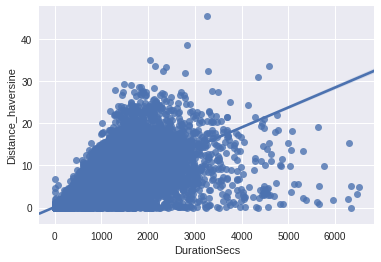

In [73]:
import seaborn as sns
%matplotlib inline

sns.regplot(x="DurationSecs", y="Distance_haversine", data=df_no_outliers)

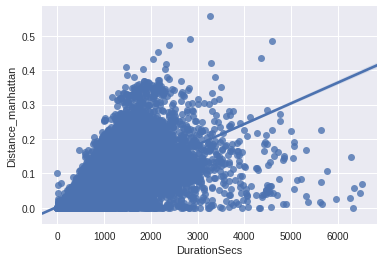

In [75]:
sns.regplot(x="DurationSecs", y="Distance_manhattan", data=df_no_outliers)

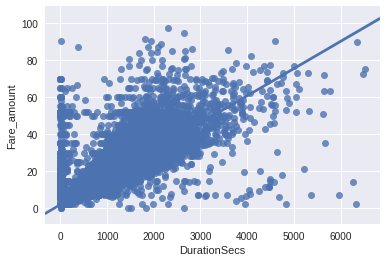

In [79]:
sns.regplot(x="DurationSecs", y="Fare_amount", data=df_no_outliers)

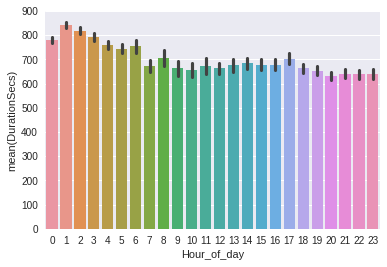

In [80]:
sns.barplot(y="DurationSecs", x="Hour_of_day", data=df_no_outliers)

## Let's try a model..

Now that we have added some features and checked that they correlate with trip duration, let's train a model and see if we added usefull information!

I'm going to try to predict trip duration from distances, location, fare and hour of day.

In [86]:
from sklearn.ensemble import RandomForestRegressor

X = df_no_outliers[['Distance_haversine', 'Distance_manhattan', 'Distance_euclidean', 'Hour_of_day',
        'Pickup_latitude', 'Pickup_longitude', 'Dropoff_latitude', 'Dropoff_longitude']]
y = df_no_outliers['Duration']

model = RandomForestRegressor(n_estimators=100, min_samples_split=50, min_samples_leaf=25)

model.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=25,
           min_samples_split=50, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Finally let's plot the feature importances to see how much information each feature provided.

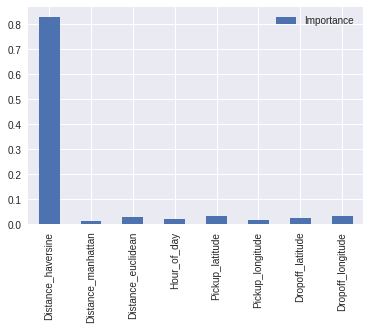

In [87]:
from matplotlib import pyplot as plt

dataz = pandas.DataFrame(model.feature_importances_, index=X.columns, columns=["Importance"])
dataz.plot(y='Importance', kind='bar')
plt.show()

So overall we seem to have added usefull features, especially the haversine distance seems to be a good predictor. Which is slightly surprising, i would expect manhattan distance to work better since taxis don't drive in straight lines...